##### Trevor Deppermann and Jessie Kong
CSE 5524 - 12:45 PM

### CSE 5524 – Virtual Drum Kit Project

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy
import skimage
from skimage import io

In [2]:
# Show desired image
def display(im):
    plt.figure()
    io.imshow(im, cmap='gray')
    plt.show()

In [3]:
# Load images
images = []
for i in range(0, 90):
    # Read in frames in grayscale
    images.append(skimage.color.rgb2gray(io.imread('frames/drums_video' + str(i).zfill(4) + '.png')))

In [4]:
# NCC template matching, which we leverage to find drums and drumsticks
def ncc(search, template, top=False, bottom=False, left=False, right=False):
    # Save dimensions of template and search images
    t_rows, t_cols = template.shape
    rows, cols = search.shape
    # Calculate number of rows above and columns left of patch center
    row_offset = t_rows // 2
    col_offset = t_cols // 2

    similarities = []

    # Calculate mean intensity value for template pixels
    t_vals = template.flatten()
    t_bar = np.mean(t_vals)
    t_std = np.std(t_vals, ddof=1)

    # Store NCC denominator, by which we divide values to get NCC result
    ncc_denom = 3 * (t_rows * t_cols - 1)

    # Iterate through all possible patches
    row_max = rows
    row_min = 0
    col_max = cols
    col_min = 0
    if top:
        row_max = rows // 6
    if bottom:
        row_min = rows // 5
    if left:
        col_max = cols // 2
    if right:
        col_min = cols // 2
        
    for center_row in range(row_min+row_offset, row_max-row_offset):
        for center_col in range(col_min+col_offset, col_max-col_offset):
            # Grab desired patch
            patch = search[center_row-row_offset:center_row+row_offset+1, center_col-col_offset:center_col+col_offset+1]
            p_vals = patch.flatten()

            # Calculate patch mean and standard deviation
            p_bar = np.mean(p_vals)
            p_std = np.std(p_vals, ddof=1)

            # Compute NCC similarity value
            if t_std != 0 and p_std != 0:
                new_vals = ((p_vals - p_bar) * (t_vals - t_bar)) / (p_std * t_std)
                ncc_val = np.sum(new_vals) / ncc_denom
            else:
                ncc_val = 0

            # Store NCC value with patch center
            similarities.append([ncc_val, center_row, center_col])

        # Print progress
        if (row_max-row_offset-center_row) % 200 == 0:
            print("Rows remaining: ", row_max-row_offset-center_row)

    # Get coordinates best match
    cr = similarities[np.argmax(similarities, axis=0)[0]][1]
    cc = similarities[np.argmax(similarities, axis=0)[0]][2]

    coords = {
        'row-min': cr - row_offset,
        'row-max': cr + row_offset + 1,
        'col-min': cc - col_offset,
        'col-max': cc + col_offset + 1
    }

    # Display best match
    display(search[coords['row-min']:coords['row-max'], coords['col-min']:coords['col-max']])

    # Return coordinates of best match
    return coords
    

Rows remaining:  200


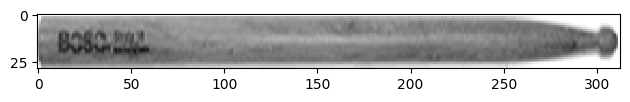

Light Drumstick Region: {'row-min': 111, 'row-max': 140, 'col-min': 100, 'col-max': 413}
Rows remaining:  200


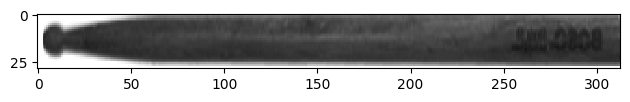

Dark Drumstick Region: {'row-min': 112, 'row-max': 141, 'col-min': 1185, 'col-max': 1498}


In [5]:
# Load in templates for light and dark drumsticks
template_light = skimage.color.rgb2gray(io.imread('original_images/drumstick_light.png')[:, :, :3])
template_dark = skimage.color.rgb2gray(io.imread('original_images/drumstick_dark.png')[:, :, :3])

# Perform NCC template matching for light drumstick
light_coords = ncc(images[0], template_light, top=True)
print('Light Drumstick Region:', light_coords)

# Perform NCC template matching for dark drumstick
dark_coords = ncc(images[0], template_dark, top=True)
print('Dark Drumstick Region:', dark_coords)

Rows remaining:  1000
Rows remaining:  800
Rows remaining:  600
Rows remaining:  400
Rows remaining:  200


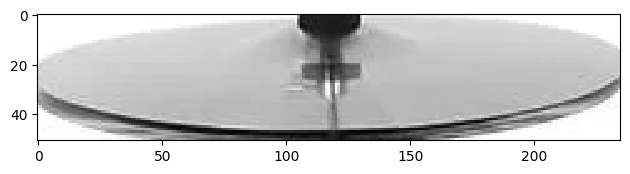

Hi-hat Region: {'row-min': 432, 'row-max': 483, 'col-min': 182, 'col-max': 417}
Rows remaining:  1000
Rows remaining:  800
Rows remaining:  600
Rows remaining:  400
Rows remaining:  200


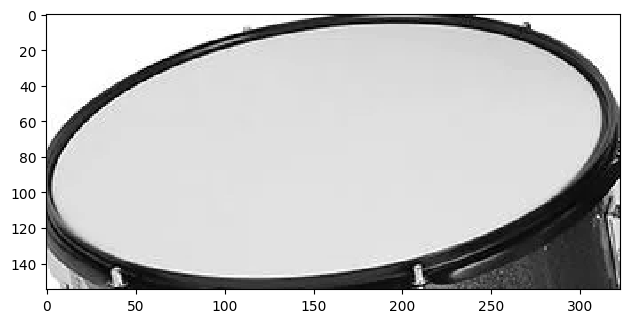

Snare Region: {'row-min': 584, 'row-max': 739, 'col-min': 70, 'col-max': 393}
Rows remaining:  1000
Rows remaining:  800
Rows remaining:  600
Rows remaining:  400
Rows remaining:  200


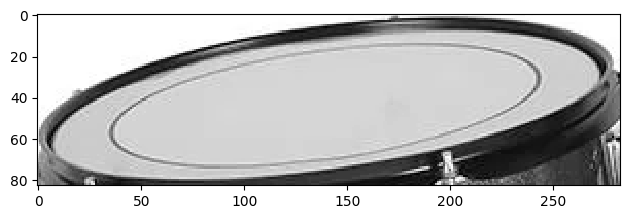

Left Tom Region:  {'row-min': 428, 'row-max': 511, 'col-min': 431, 'col-max': 714}


In [6]:
# Find left-side drum kit components

# Load in templates for snare, hihat, and left-tom drums
template_hihat = skimage.color.rgb2gray(io.imread('original_images/hihat.jpeg')[:, :, :3])
template_snare = skimage.color.rgb2gray(io.imread('original_images/snare.jpeg')[:, :, :3])
template_lefttom = skimage.color.rgb2gray(io.imread('original_images/lefttom.jpeg')[:, :, :3])

# Get hihat region
hihat_coords = ncc(images[0], template_hihat, bottom=True, left=True)
print('Hi-hat Region:', hihat_coords)

# Get snare region
snare_coords = ncc(images[0], template_snare, bottom=True, left=True)
print('Snare Region:', snare_coords)

# Get left tom region
lefttom_coords = ncc(images[0], template_lefttom, bottom=True, left=True)
print('Left Tom Region: ', lefttom_coords)

Rows remaining:  1000
Rows remaining:  800
Rows remaining:  600
Rows remaining:  400
Rows remaining:  200


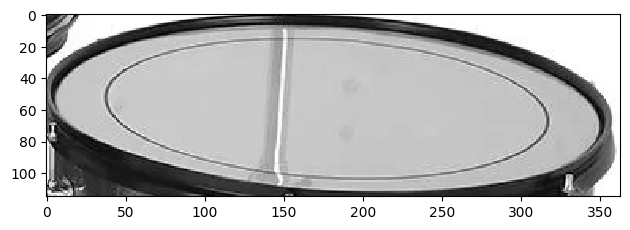

Floor Tom Region: {'row-min': 682, 'row-max': 797, 'col-min': 1103, 'col-max': 1466}
Rows remaining:  1000
Rows remaining:  800
Rows remaining:  600
Rows remaining:  400
Rows remaining:  200


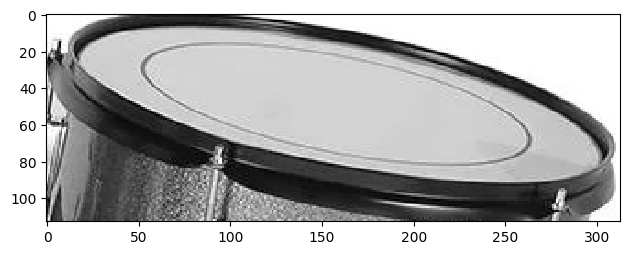

Right Tom Region: {'row-min': 401, 'row-max': 514, 'col-min': 857, 'col-max': 1170}
Rows remaining:  1200
Rows remaining:  1000
Rows remaining:  800
Rows remaining:  600
Rows remaining:  400
Rows remaining:  200


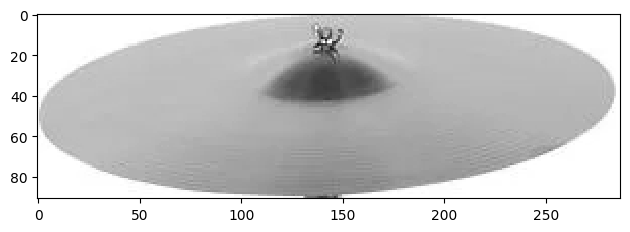

Crash Region:  {'row-min': 231, 'row-max': 322, 'col-min': 1131, 'col-max': 1418}


In [7]:
# Find right-side drum kit components

# Load in templates for snare, hihat, and left-tom drums
template_floortom = skimage.color.rgb2gray(io.imread('original_images/floortom.jpeg')[:, :, :3])
template_righttom = skimage.color.rgb2gray(io.imread('original_images/righttom.jpeg')[:, :, :3])
template_crash = skimage.color.rgb2gray(io.imread('original_images/crash.jpeg')[:, :, :3])

# Get floor tom region
floortom_coords = ncc(images[0], template_floortom, bottom=True, right=True)
print('Floor Tom Region:', floortom_coords)

# Get right tom region
righttom_coords = ncc(images[0], template_righttom, bottom=True, right=True)
print('Right Tom Region:', righttom_coords)

# Get crash region
crash_coords = ncc(images[0], template_crash, right=True)
print('Crash Region: ', crash_coords)


In [7]:
# Define helper methods for mean-shift tracking

# Return feature matrix for pixels in neighborhood
def circularNeighbors(img, x, y, radius):
    # Store fk value for each pixel in neighborhood
    fk_matrix = np.empty((0, 3), int)

    # Iterate through possible neighborhood pixels, instead of all image pixels
    for i in range(math.floor(x) - radius, math.ceil(x) + radius):
        for j in range(math.floor(y) - radius + 1, math.ceil(y) + radius):
            # Calculate distance from center
            dist = math.sqrt(pow(i - x, 2) + pow(j - y, 2))
            # Ensure distance is less than radius
            if dist < radius:
                # Extract pixel intensity
                intensity = img[i, j]
                # Calculate feature vector and add to matrix
                fk = [i, j, intensity]
                fk_matrix = np.vstack((fk_matrix, np.array(fk)))
                
    return fk_matrix


# Return bin index based on bounds and value
def get_bin(lower_bounds, val):
    for i in range(len(lower_bounds)-1, -1, -1):
        if val >= lower_bounds[i]:
            return i
    return -1


# Return histogram
def intensityHistogram(X, bins, x, y, h):
    # Initialize histogram
    hist = np.zeros(bins)

    # Determine lower bounds of each histogram bin
    bin_lower_bounds = np.linspace(0, 1, bins+1)[:-1]

    # Iterate through all pixels of neighborhood
    for i in range(len(X)):
        intensity = X[i, 2]
        # Calculate weight
        x_dist = x - X[i][0]
        y_dist = y - X[i][1]
        epan_val = pow(math.sqrt(x_dist*x_dist + y_dist*y_dist) / h, 2)

        if epan_val < 1:
            epan_val = 1 - epan_val
        else:
            epan_val = 0

        # Determine bin for color component
        bin_num = get_bin(bin_lower_bounds, intensity)

        hist[bin_num] += epan_val

    # Normalize histogram
    hist /= np.sum(hist)

    return hist


# Return vector of pixel weights
def meanshiftWeights(X, q_model, p_test, bins):
    # Determine size of each histogram bin
    bounds = np.linspace(0, 1, bins + 1)[:-1]

    # Store weight for each pixel in neighborhood
    w = []

    # Iterate through all bins
    for i in range(len(X)):
        val = X[i, 2]
        # Find bin of current pixel, then update weight
        bin_num = get_bin(bounds, val)
        wi = math.sqrt(q_model[bin_num] / p_test[bin_num])
        # Add pixel weight to vector
        w.append(wi)

    return w

In [36]:
light_stick_locations = get_locations_by_frame(images, light_r, light_c)
dark_stick_locations = get_locations_by_frame(images, dark_r, dark_c)

0 [125, 256]
1 [152.17526746 261.0818496 ]
2 [183.23647828 264.94091982]
3 [210.10157703 269.34198828]
4 [236.60642154 285.84063051]
5 [262.51452816 301.06612265]
6 [285.22181985 310.78718343]
7 [302.41513825 307.8303577 ]
8 [329.35361317 317.83294905]
9 [336.7976177  306.07913916]
10 [321.45093387 304.19182546]
11 [301.93837553 303.88310418]
12 [282.12319613 305.92372852]
13 [282.39168935 305.65231515]
14 [282.4554008  305.50293975]
15 [282.49563902 305.49752654]
16 [282.5250884  305.49429594]
17 [282.5082138  305.50010003]
18 [282.50279799 305.49974166]
19 [282.5127413  305.50066197]
20 [282.52095151 305.49219905]
21 [282.49858377 305.50133291]
22 [282.51644868 305.50046453]
23 [300.0975715  279.09005414]
24 [298.30608634 292.19238315]
25 [336.32201608 294.90821775]
26 [336.49753216 294.49984062]
27 [336.49995922 294.49999719]
28 [336.49999933 294.49999995]
29 [336.49999999 294.5       ]
30 [336.5 294.5]
31 [336.5 294.5]
32 [336.5 294.5]
33 [336.5 294.5]
34 [336.5 294.5]
35 [336.5 29

In [13]:
def gauss_deriv_2d(sigma):
    size = math.ceil(3*sigma)
    origin = math.floor(size/2)
    Gx = np.fromfunction(lambda y,x: (-(x-origin)/(2*np.pi*(sigma**4)))*np.exp((-((x-origin)**2+(y-origin)**2)/(2*sigma**2))), (size,size), dtype = float)
    Gy = Gx.transpose()
    #normalize Gx and Gy
    Gx /= np.sum(np.abs(Gx))
    Gy /= np.sum(np.abs(Gy))
    return Gx,Gy

In [20]:
#harris detector
from skimage import filters
def harrisDetector(image, template, r, c):
    sigma = 0.7
    Gx, Gy = gauss_deriv_2d(sigma)
    gxIm = scipy.ndimage.convolve(image, Gx, mode='nearest')
    gyIm = scipy.ndimage.convolve(image, Gy, mode='nearest')
    #get image derivatives
    gxImSquared = gxIm*gxIm
    gyImSquared = gyIm*gyIm
    gxGy = gxIm*gyIm

    #blur image derivates
    Ix = filters.gaussian(gxImSquared, sigma=1)
    Iy = filters.gaussian(gyImSquared, sigma=1)
    IxIy = filters.gaussian(gxGy, sigma=1)


    #calculate R
    alpha = 0.0005
    R = (Ix*Iy) - (IxIy**2) - alpha*(Ix+Iy)**2

    #set threshold 
    RThreshold = np.copy(R)
    RThreshold [RThreshold < .000001 ] = 0  
    plt.imshow(RThreshold, cmap='gray')
    plt.title("Harris Detector with Threshold")
    plt.show()
    #get index of max value in RThreshold (drumstick tip)
    index = np.argmax(RThreshold)
    #get coordinates of index
    drumstick_tip = np.unravel_index(index, RThreshold.shape) 

    #display the corner point detected
    plt.imshow(image, cmap='gray')
    plt.scatter(drumstick_tip[1], drumstick_tip[0], c='r', s=60) 
    plt.title('Point in Template')
    plt.show()
    # Calculate number of rows above and columns left of patch center
    t_rows, t_cols = template.shape
    row_offset = t_rows // 2
    col_offset = t_cols // 2
    x_val = drumstick_tip[1] + c - col_offset -1
    y_val = drumstick_tip[0] + r - row_offset -1
    return x_val, y_val

start


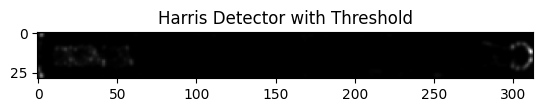

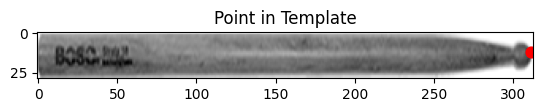

In [31]:
#Get interesting point for light drumstick
print('start')
light_corner_row, light_corner_col = harrisDetector(light_patch_im, template_light, light_r, light_c)

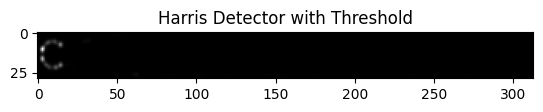

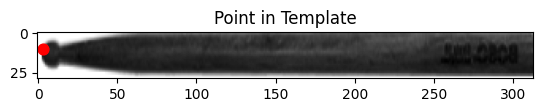

In [32]:
# Get interesting point for dark drum stick
dark_corner_row, dark_corner_col = harrisDetector(dark_patch_im, template_dark, dark_r, dark_c)

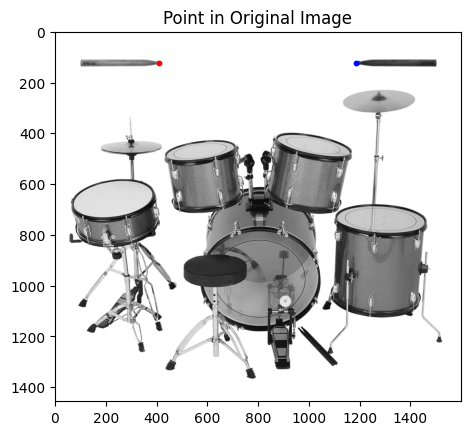

In [33]:
#display the point detected
plt.imshow(images[0], cmap='gray')
plt.scatter(light_x_val, light_y_val , c='r', s=10) 
plt.scatter(dark_x_val, dark_y_val , c='b', s=10) 
plt.title('Point in Original Image')
plt.show()

In [34]:
# Use mean-shift tracking to return location of desired object in each frame
def get_locations_by_frame(im_seq, initial_row, initial_col):
    
    # Initialize list of locations per im_seq frame, to be returned
    locations = np.zeros((len(im_seq), 2))

    # Set parameters for mean-shift tracking
    radius = 40
    # neighbor_radius = 10
    bins = 16

    # Set initial location
    loc = [initial_row, initial_col]
    locations[0] = loc
    print("0", loc)

    # Iterate through each image frame
    for im_num in range(1, len(im_seq)):
        
        # Build model histogram
        model_cn = circularNeighbors(im_seq[im_num-1], loc[0], loc[1], radius)
        model_hist = intensityHistogram(model_cn, bins, loc[0], loc[1], radius)

        # Perform mean-shift tracking on new image a certain number of times
        for iterations in range(25):
            candidate_cn = circularNeighbors(im_seq[im_num], loc[0], loc[1], radius)
            candidate_hist = intensityHistogram(candidate_cn, bins, loc[0], loc[1], radius)
            w = meanshiftWeights(candidate_cn, model_hist, candidate_hist, bins)
        
            # Perform mean shift - find next best location
            numerator = np.zeros(2)
            denominator = 0
            for i in range(len(candidate_cn)):
                numerator = numerator + [x * w[i] for x in candidate_cn[i, :2]]
                denominator += w[i]
        
            # Update location
            loc = numerator / denominator
        
        # Print results
        print(im_num, loc)
    
        # Save final location for frame
        locations[im_num] = loc

    return locations


In [35]:
#get light drumstick location
light_drumtip_locations = get_locations_by_frame(images, light_corner_row, light_corner_col)

0 [410, 122]
1 [410. 122.]
2 [410. 122.]
3 [410. 122.]
4 [410. 122.]
5 [410. 122.]
6 [410. 122.]
7 [410. 122.]
8 [410. 122.]


KeyboardInterrupt: 

In [39]:
#get light drumstick location
print('start')
light_drumtip_locations2 = get_locations_by_frame(images, light_y_val, light_x_val)

start
0 [122, 410]
1 [141.28156756 410.60554477]
2 [141.5 410.5]
3 [141.5 410.5]
4 [141.5 410.5]
5 [141.5 410.5]
6 [141.5 410.5]
7 [141.5 410.5]
8 [141.5 410.5]
9 [141.5 410.5]
10 [141.5 410.5]
11 [141.5 410.5]
12 [141.5 410.5]
13 [141.5 410.5]
14 [141.5 410.5]
15 [141.5 410.5]


KeyboardInterrupt: 

In [60]:
#get dark drumstick location
dark_drumtip_locations = get_locations_by_frame(images, dark_y_val, dark_x_val)

0 [121, 1187]
1 [ 118.39265963 1181.78978598]
2 [ 120.92859808 1182.5196112 ]
3 [ 130.81367243 1184.4259877 ]
4 [ 145.75449316 1185.2066281 ]
5 [ 158.43748415 1183.98168165]
6 [ 174.16155659 1185.30842106]
7 [ 185.86378345 1183.94667369]
8 [ 190.36034213 1191.56921371]
9 [ 191.29070083 1202.99270456]
10 [ 190.56360027 1210.92755273]
11 [ 190.40753107 1211.43579859]
12 [ 190.38897304 1211.42485152]
13 [ 190.37801214 1211.41887767]
14 [ 190.37467252 1211.4179224 ]
15 [ 190.37370694 1211.41767461]
16 [ 190.37342944 1211.41760437]
17 [ 190.37334974 1211.41758424]
18 [ 190.37332686 1211.41757845]
19 [ 190.37332028 1211.41757679]
20 [ 190.3733184  1211.41757632]
21 [ 190.37331785 1211.41757618]
22 [ 190.3733177  1211.41757614]
23 [ 190.37331765 1211.41757613]
24 [ 190.37331764 1211.41757612]
25 [ 190.37331764 1211.41757612]
26 [ 190.37331764 1211.41757612]
27 [ 190.37331764 1211.41757612]
28 [ 190.37331764 1211.41757612]
29 [ 190.37331764 1211.41757612]
30 [ 190.37385064 1211.41773997]
31 [ 

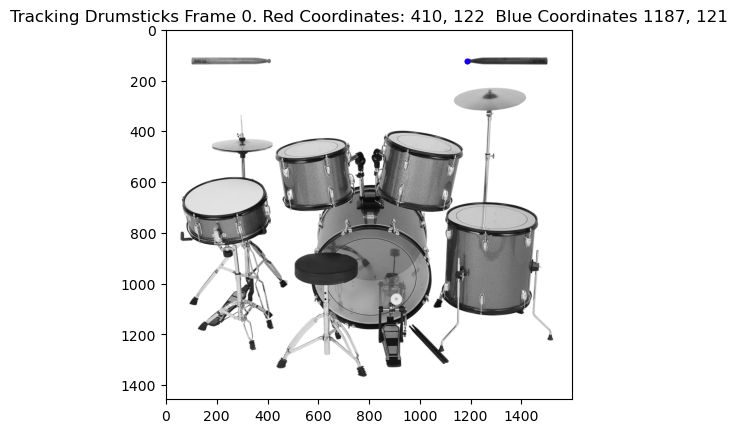

In [61]:
#display the point detected
plt.imshow(images[0], cmap='gray')
plt.scatter(light_drumtip_locations[0][1],light_drumtip_locations[0][0], c='r', s=10) 
plt.scatter( dark_drumtip_locations[0][1],dark_drumtip_locations[0][0], c='b', s=10) 
plt.title('Tracking Drumsticks Frame 0. Red Coordinates: 410, 122  Blue Coordinates 1187, 121')
plt.show()

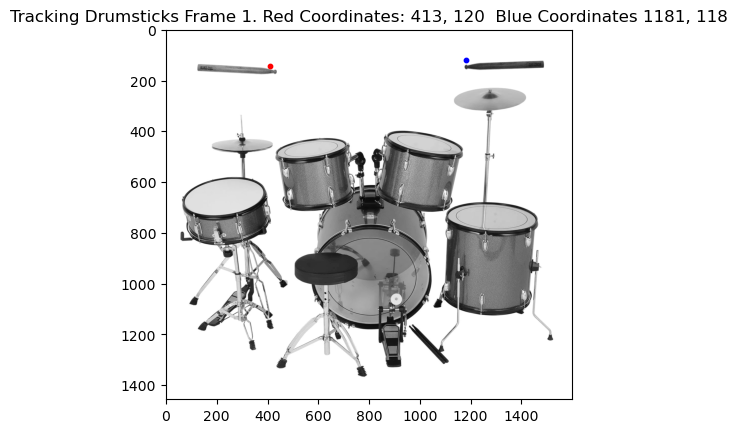

In [31]:
#display the point detected
plt.imshow(images[1], cmap='gray')
plt.scatter( 409.5891308,143.88608818, c='r', s=10) 
plt.scatter( 1181.78978598, 118.39265963, c='b', s=10) 
plt.title('Tracking Drumsticks Frame 1. Red Coordinates: 413, 120  Blue Coordinates 1181, 118')
plt.show()

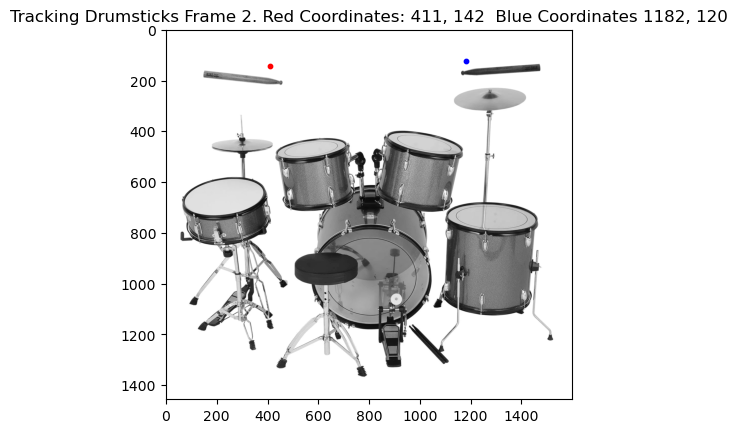

In [57]:
#display the point detected
plt.imshow(images[2], cmap='gray')
plt.scatter( 411.34020171, 142.68638512,c='r', s=10) 
plt.scatter( 1182.5196112,120.92859808,  c='b', s=10) 
plt.title('Tracking Drumsticks Frame 2. Red Coordinates: 411, 142  Blue Coordinates 1182, 120')
plt.show()

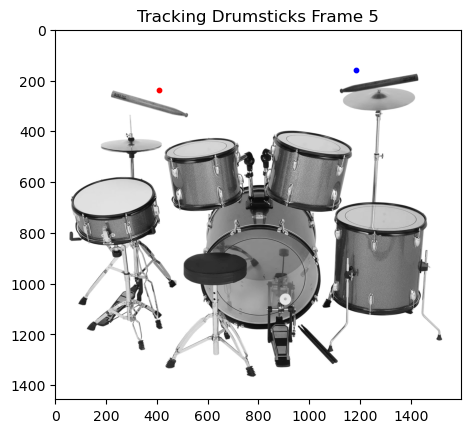

In [48]:

#display the point detected
plt.imshow(images[5], cmap='gray')
plt.scatter(407.04079414, 236.00340575, c='r', s=10) 
plt.scatter(1183.98168165, 158.43748415,  c='b', s=10) 
plt.title('Tracking Drumsticks Frame 5')
plt.show()

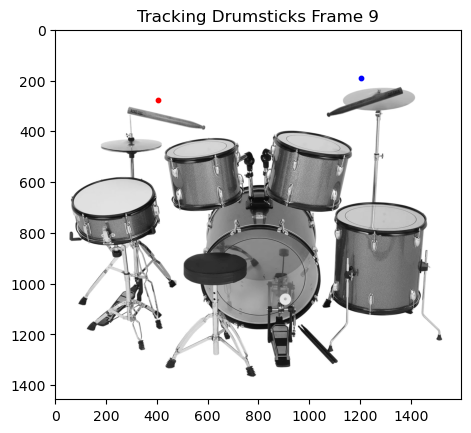

In [51]:

#display the point detected
plt.imshow(images[9], cmap='gray')
plt.scatter(404.00903963, 274.60703533, c='r', s=10) 
plt.scatter(1202.99270456, 191.29070083,  c='b', s=10) 
plt.title('Tracking Drumsticks Frame 9')
plt.show()

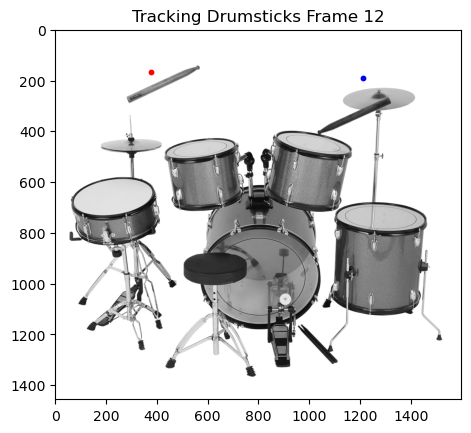

In [52]:
#display the point detected
plt.imshow(images[12], cmap='gray')
plt.scatter(378.6693708, 164.44867181, c='r', s=10) 
plt.scatter(1211.42485152, 190.38897304,  c='b', s=10) 
plt.title('Tracking Drumsticks Frame 12')
plt.show()